In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

In [16]:
class KernelRidgeRegression: 
    def __init__(self,lambda_param=1.0):
        self.lambda_param = lambda_param
    def kernel(self, X, Z, kernel_type='rbf', gamma=30, degree=3):
        """Compute the kernel matrix"""
        if kernel_type == 'linear':
            return X @ Z.T
        elif kernel_type == 'rbf':
            return np.exp(-gamma * cdist(X, Z, 'sqeuclidean'))
        elif kernel_type == 'poly':
            return (X @ Z.T + 1)**degree
    def loss_function(self, X, y, alpha):
        """Calculate the training loss function value"""
        n = X.shape[0]
        K = self.kernel(X, X)
        residual = y - K @ alpha
        loss = (residual.T @ residual) / (2 * n) + (self.lambda_param / 2) * (alpha.T @ K @ alpha)
        return loss
    def predictions(self, X_train,X_test, alpha):
        """Make predictions"""
        predictions = self.kernel(X_test,X_train) @ alpha 
        #return np.sign(predictions)
        return np.round(predictions).astype(int)
    def accuracy(self, X_train,X_test, y, alpha):
        """Calculate the accuracy"""
        return accuracy_score(y, self.predictions(X_train,X_test, alpha))
    def test_loss_function(self, X_train,X_test, y, alpha):
        """Calculate the test loss function value"""
        n= X_test.shape[0]
        loss = 1/(2*n) * np.linalg.norm(y-self.kernel(X_test,X_train)@alpha)**2
        return loss
    def gradient(self, X, y, alpha):
        """Calculate the gradient of the loss function"""
        n= X.shape[0]
        K = self.kernel(X,X)
        grad = K@((1/n * K + self.lambda_param * np.identity(n)) @ alpha - 1/n * y)
        #1/n * K @ (K@alpha - y) + self.lambda_param * K@alpha
        return grad
    def gradient_descent(self, X, y, alpha_init, learning_rate, max_iters, loss_target):
        alpha_values = []
        alpha = alpha_init
        i=0
        alpha_values.append(alpha)
        while self.loss_function(X, y, alpha) > loss_target and i < max_iters-1:
        #grad = self.gradient(X, y, alpha)
        #while np.linalg.norm(grad) > loss_target and i < max_iters-1:
            grad = self.gradient(X, y, alpha)
            alpha = alpha - learning_rate * grad
            i+=1
            alpha_values.append(alpha)
        #print(f'Number of iterations: {i}')
        return alpha,alpha_values

    def constante_L(self, X):
        """Compute the Lipschitz constant"""
        n= X.shape[0]
        K= self.kernel(X,X)
        eigenvals,_ = np.linalg.eigh(1/n * K.T@K + self.lambda_param * K)
        L = np.max(eigenvals)
        mu = np.min(eigenvals)
        return L,mu
    def alpha_opt(self, X, y):
        """Compute the optimal w for the training set"""
        n= X.shape[0]
        alpha = np.linalg.solve(self.kernel(X,X) + n *self.lambda_param * np.identity(n) , y)
        return alpha
    
    def compute_errors(self, X_train, X_test, y_train, y_test, alpha):
        """Compute training and test errors"""
        train_predictions = self.predictions(X_train,X_train, alpha)
        test_predictions = self.predictions(X_train,X_test, alpha)
        train_error = np.mean(np.sign(train_predictions) != y_train)
        test_error = np.mean(np.sign(test_predictions) != y_test)
        return train_error, test_error
    
    def plot_level_sets(self, X_train,X_test, y_train,y_test, w1,w2=None,w_3=None):
        """Plot level sets of the loss and the risk function"""
        alpha_range = np.linspace(-1, 1, 60) # value of first component of alpha
        beta_range = np.linspace(-1, 1, 60) # value of second component of alpha
        A, B = np.meshgrid(alpha_range, beta_range)
        Z_l = np.zeros_like(A)
        Z_r = np.zeros_like(A)
        alpha_opt = self.alpha_opt(X_train, y_train)
        for i in range(A.shape[0]):
            for j in range(A.shape[1]):
                alpha_temp = alpha_opt.copy()
                alpha_temp[0] = A[i, j]
                alpha_temp[1] = B[i, j]
                Z_l[i, j] = self.loss_function(X_train, y_train, alpha_temp)
                Z_r[i, j] = self.test_loss_function(X_train,X_test, y_test, alpha_temp)  
    
        w_train = self.alpha_opt(X_train,y_train)
        
        min_risk_index = np.unravel_index(np.argmin(Z_r, axis=None), Z_r.shape)
        
        
        plt.figure()
        plt.contour(A, B, Z_l, levels=50, cmap='viridis', alpha=0.5)
        plt.contour(A, B, Z_r, levels=50, cmap='inferno', alpha=0.5, linestyles='dotted')

        plt.plot(np.array(w1)[:,0], np.array(w1)[:,1], color='black')
        plt.plot(np.array(w2)[:,0], np.array(w2)[:,1], color='green')
        if w_3 is not None:
            plt.plot(np.array(w_3)[:,0], np.array(w_3)[:,1], color='yellow')

        plt.scatter(w_train[0],w_train[1],color='red')
        plt.scatter(A[min_risk_index], B[min_risk_index], color='blue')
        # for alpha in Model_2.alpha_values[:Model_2.ite_max]:
        #     plt.scatter(alpha[0],alpha[1],color='green')  
        # for alpha in self.alpha_values[:self.ite_max]:
        #     plt.scatter(alpha[0],alpha[1],color='black') 
        # plt.scatter(alpha_train[0],alpha_train[1],color='red')

        plt.xlabel('Alpha 1')
        plt.ylabel('Alpha 2')
        plt.title('Level Sets of the Loss Function')
        legend_elements = [Line2D([0], [0], color='red', lw=2, label='Loss Function'),
                   Line2D([0], [0], color='blue', lw=2, label='Test loss Function'),
                   Line2D([0],[0],color='green', marker='o',linestyle='None',label='w2'),
                    Line2D([0],[0],color='black', marker='o',linestyle='None',label='w1'),
                    Line2D([0],[0],color='yellow', marker='o',linestyle='None',label=f'Chebyshev')]
        
        plt.legend(handles=legend_elements)
        plt.grid(True)
        #plt.savefig("Level_set.pdf")
        plt.show()

In [17]:
# Load the dataset
data = np.load(r'C:\Users\accol\OneDrive\Documents\Mémoire\ckn_mnist.npz')

# Access the arrays in the dataset
images = data['X']
labels = data['y']
# Convert labels: 1 if label=0, -1 otherwise
#labels = np.where(labels == 1, 1, -1)

print(f"Images shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Images shape: (60000, 2304)
Labels shape: (60000, 1)


In [18]:
n=50
x_values = np.random.randint(0, images.shape[0] - n, size=10)
x=x_values[0]
# Take only n images for training
images = images[x:x+n]
labels = labels[x:x+n]
# Separet the dataset into training and testing
n_train = int(n*0.8)
train_images = images[:n_train]
train_labels = labels[:n_train]
test_images = images[n_train:]
test_labels = labels[n_train:]

# Reshape the images to 2D
train_images = train_images.reshape(train_images.shape[0], -1)
test_images = test_images.reshape(test_images.shape[0], -1)
train_labels = train_labels.reshape(-1)
test_labels = test_labels.reshape(-1)

In [19]:
alpha_init = np.ones(train_images.shape[0])*5
model = KernelRidgeRegression(lambda_param=0)
L,mu = model.constante_L(train_images)
alpha,alpha_values = model.gradient_descent(train_images, train_labels, alpha_init, 1.99/L, 100, 0)
accuracy = model.accuracy(train_images,test_images,test_labels,alpha)
train_accuracy = model.accuracy(train_images,train_images,train_labels,alpha)
loss = model.loss_function(train_images, train_labels, alpha)
test_loss = model.test_loss_function(train_images, test_images, test_labels, alpha)

print(f"Train Loss: {loss}")
print(f"Test Loss: {test_loss}")
print(f"Train accuracy: {train_accuracy}")
print(f"Test Accuracy: {accuracy}")

Train Loss: 0.01191032034361568
Test Loss: 11.171849911788069
Train accuracy: 0.95
Test Accuracy: 0.4


24.574641418356524
18.487079038271567
3.0368607143560085
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 2
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number of iterations: 3
number 

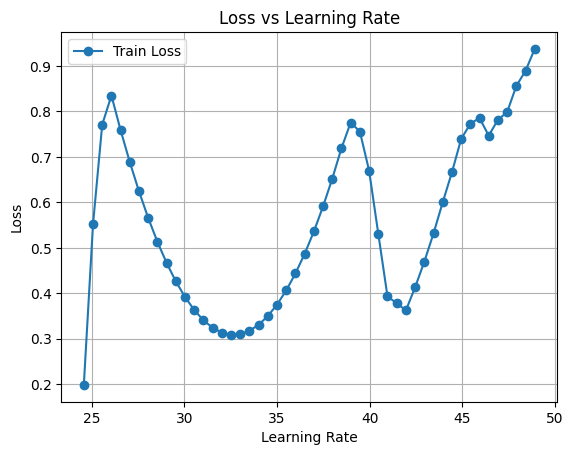

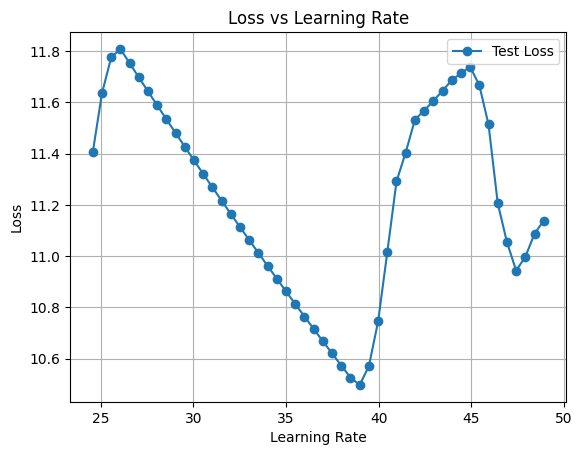

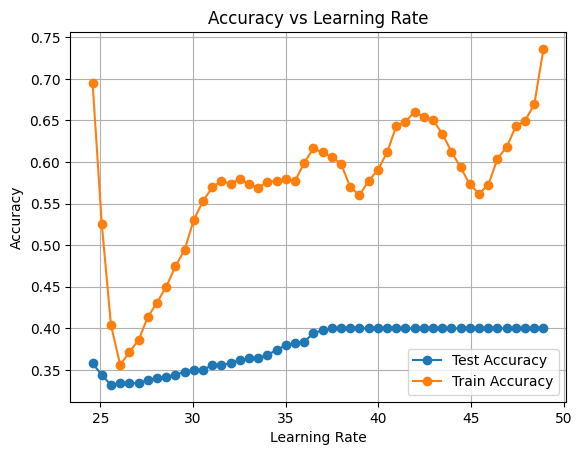

In [21]:
model = KernelRidgeRegression(lambda_param=0)
L,mu = model.constante_L(train_images)
print(1/L)
print(1/(L+mu))
print(L/mu)
learning_rates_s = np.linspace(1/L, 1.99/L, num=50)
initializations = [np.random.randn(train_images.shape[0]) for _ in range(50)]

accuracies = []
test_loss = []
training_loss =[]
training_accuracies=[]

for lr in learning_rates_s:
    acc_list = []
    train_acc_list = []
    test_loss_list = []
    train_loss_list = []
    for init in initializations:
        alpha, alpha_values = model.gradient_descent(train_images,train_labels,init.copy(),lr,10000,1)
        accuracy = model.accuracy(train_images,test_images,test_labels,alpha)
        loss = model.test_loss_function(train_images, test_images, test_labels, alpha)
        train_loss = model.loss_function(train_images,train_labels,alpha)
        train_accuracy = model.accuracy(train_images,train_images, train_labels, alpha)
        acc_list.append(accuracy)
        test_loss_list.append(loss)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_accuracy)
        print(f"number of iterations: {len(alpha_values)}")
    accuracies.append(np.mean(acc_list))
    test_loss.append(np.mean(test_loss_list))
    training_loss.append(np.mean(train_loss_list))
    training_accuracies.append(np.mean(train_acc_list))

plt.figure()

plt.plot(learning_rates_s, training_loss, marker='o', linestyle='-', label='Train Loss')
plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Loss vs Learning Rate')
plt.grid(True)
#plt.savefig('Train_loss.pdf')
plt.show()
plt.figure()
plt.plot(learning_rates_s, test_loss, marker='o', linestyle='-',label = 'Test Loss')

plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Loss vs Learning Rate')
plt.grid(True)
#plt.savefig('Train_loss.pdf')
plt.show()

plt.figure()
plt.plot(learning_rates_s, accuracies, marker='o', linestyle='-', label='Test Accuracy')
plt.plot(learning_rates_s, training_accuracies, marker='o', linestyle='-', label='Train Accuracy')
plt.legend()
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')
plt.grid(True)
#plt.savefig('Accuracy.pdf')
plt.show()
